<div class="usecase-title">Analyzing the Impact of Time, Weather and Traffic on Bike and Car Usage</div>

<div class="usecase-authors"><b>Authored by: </b> Kushani Imanthi Ranasinghe</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, jupyter Notebook, Data Analysis, and Machine Learning</div>
</div>

<div class="usecase-section-header">Scenario</div>

As a city planner in Melbourne, I want to analyze how factors like time, weather, and traffic influence bike and car usage,
so that I can identify trends, optimize transportation policies, and improve road safety while encouraging sustainable travel modes.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Data Wrangling and Preprocessing: Gain expertise in handling multiple datasets, including bike-sharing data, traffic data, and historical weather data, cleaning and preparing them for analysis.
- Exploratory Data Analysis (EDA): Learn to visualize and analyze time-based, weather-related, and traffic trends to uncover meaningful patterns and relationships.
- Statistical Analysis: Apply statistical techniques to determine the correlation and causation between weather, traffic, and transportation choices.
- Data Integration: Develop skills in merging diverse datasets (e.g:- spatial and temporal alignment of traffic and bike data with weather conditions).
- Predictive Modeling: Build and evaluate machine learning models to predict bike and car usage based on external factors such as time and weather.
- Visualization and Reporting: Create compelling visualizations and dashboards to communicate insights effectively to stakeholders.
- Domain Knowledge in Transport and Safety: Understand the interplay between transportation choices and environmental conditions, fostering data-driven decision-making for urban planning and safety.

<div class="usecase-section-header"><b>Investigating the Impact of Time, Weather, and Traffic Conditions on Bike and Car Usage in Melbourne</b></div>

Urban transportation systems face increasing challenges as cities grow, with rising traffic congestion, environmental concerns, and safety risks. Understanding the factors that influence transportation choices, such as weather conditions, traffic flow, and time patterns, is critical for designing efficient and sustainable systems. This use case focuses on analyzing how these factors impact bike usage as a sustainable transport option and car usage as a default alternative, highlighting the interplay between environmental conditions and commuter behavior.

The analysis leverages three primary datasets: Melbourne bike-share station readings (2011–2017), traffic count and vehicle classification data (2014–2017), and historical weather data. The bike-share, traffic datasets, and weather data are sourced from Melbourne's open data portal. By integrating these datasets, this use case aims to uncover actionable insights into how time, weather, and traffic influence transportation choices, ultimately supporting safer and more sustainable urban mobility planning.

<div class="usecase-section-header"><b>Datasets used</b></div>

- [Melbourne Bike Share Station Readings 2011-2017](https://data.melbourne.vic.gov.au/explore/dataset/melbourne-bike-share-station-readings-2011-2017/information/)<br>
This dataset contains the bike share station readings across Melbourne, including the number of bikes available, the number of bikes in use, and station details. It helps track bike usage patterns in relation to weather, time, and traffic conditions. This dataset is sourced from the Melbourne Open Data website and can be accessed using API V2.1.</p>

- [Traffic Count Vehicle Classification 2014-2017](https://data.melbourne.vic.gov.au/explore/dataset/traffic-count-vehicle-classification-2014-2017/table/?sort=date)<br>
This dataset includes traffic counts and vehicle classifications (e.g:- cars, trucks, motorcycles) across various locations in Melbourne. The data helps in analyzing traffic patterns and their impact on bike usage. This dataset is also imported from the Melbourne Open Data website using API V2.1.

- [Weather stations (historical data)](https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-1/information/)<br>
This dataset provides weather-related information such as temperature, humidity, precipitation, and wind speed for Melbourne. Weather data helps assess how different weather conditions influence the choice between bike and car usage. This dataset is also imported from the Melbourne Open Data website using API V2.1.

### Required Libraries and Packages

In [290]:
!pip install folium
!pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from folium.plugins import MarkerCluster
import geopandas as gpd
import requests
from io import StringIO
from io import BytesIO
from zipfile import ZipFile

### Loading the datasets using API 2.1v

In [292]:
#Function to collect data
def API_Unlimited(datasetname): # pass in dataset name and api key
    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(datasetname.sample(10, random_state=999)) # Test
        return datasetname
    else:
        return (print(f'Request failed with status code {response.status_code}'))


# Function to fetch data from a URL
def fetch_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = pd.read_csv(StringIO(response.content.decode('utf-8')))
        print(data.head())  # Display the first few rows for verification
        return data
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None


# Function to fetch and extract data from a zipped URL
def fetch_and_extract_zip(url):
    # Send a GET request to fetch the content of the zip file
    response = requests.get(url)
    if response.status_code == 200:
        # Open the zip file from the response content
        with ZipFile(BytesIO(response.content)) as zf:
            # List the files in the zip archive
            file_names = zf.namelist()
            print(f"Files in the archive: {file_names}")
            
            for file_name in file_names:
                if file_name.endswith('.csv'):
                    # Read the CSV file into a DataFrame
                    with zf.open(file_name) as csv_file:
                        data = pd.read_csv(csv_file)
                        print(data.head())  # Display the first few rows for verification
                        return data
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# URL for the bike share data
bike_share_dataset_url = 'https://opendatasoft-s3.s3.amazonaws.com/downloads/archive/74id-aqj9.zip'

In [294]:
# Use functions to download and load data
dataset_id_1 = 'traffic-count-vehicle-classification-2014-2017'
dataset_id_2 = 'meshed-sensor-type-1'

traffic_count_dataset = API_Unlimited(dataset_id_1)
weather_dataset = API_Unlimited(dataset_id_2)

# Fetch and process the bike share data
bike_share_df = fetch_and_extract_zip(bike_share_dataset_url)

             date            road_name  \
2711   2015-10-23        Bourke Street   
54109  2015-03-09  Princess Park Drive   
47736  2015-08-26      Gatehouse Drive   
28042  2016-10-13     Gatehouse Street   
59703  2014-09-11      Tennyson Street   
31485  2017-05-03           Epsom Road   
11816  2015-05-30        Lytton Street   
15809  2014-04-02     Elizabeth Street   
36506  2014-10-11      Wolseley Parade   
54876  2015-03-09         Story Street   

                                               location         suburb  \
2711           Between Geographe Street and Import Lane      Docklands   
54109                        South of MacPherson Street  Carlton North   
47736         Between Smithfield Road and Stockmans Way     Kensington   
28042            Between Story Street and Morrah Street      Parkville   
59703                      South West of Southey Street     Kensington   
31485         Between Bangalore Street and The Ridgeway     Kensington   
11816          Betw

In [296]:
# Retrieve the "Traffic Count" dataset
print(f'The shape of dataset is {traffic_count_dataset.shape}.')
print('Below are the first few rows of this dataset:')

# Display the first few rows of each dataset
print("Traffic Count Dataset:")
print(traffic_count_dataset.head())

# --------------------

# Retrieve the "Weather History" dataset
print(f'The shape of dataset is {weather_dataset.shape}.')
print('Below are the first few rows of this dataset:')

# Display the first few rows of each dataset
print("Weather History Dataset:")
print(weather_dataset.head())

# ---------------------

# Retrieve the "Bike Share" dataset
print(f'The shape of dataset is {bike_share_df.shape}.')
print('Below are the first few rows of this dataset:')

# Display the first few rows of each dataset
print("Bike Share Dataset:")
print(bike_share_df.head())

The shape of dataset is (60168, 28).
Below are the first few rows of this dataset:
Traffic Count Dataset:
         date     road_name                location      suburb  speed_limit  \
0  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
1  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
2  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
3  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
4  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   

  direction   time  vehicle_class_1  vehicle_class_2  vehicle_class_3  ...  \
0         S   3:00              1.0              0.0              0.0  ...   
1         S   5:00              6.0              0.0              0.0  ...   
2         S   8:00             70.0              0.0              0.0  ...   
3         S  10:00             34.0              0.0              2.0  ...   
4         S  12:00     

### Data Cleaning and Preparation

In [298]:
# ---------------------------------------------
# Data Cleaning and Preparation (used mean imputation)
# ---------------------------------------------

## Convert date columns to datetime format
traffic_count_dataset['date'] = pd.to_datetime(traffic_count_dataset['date'], errors='coerce')
weather_dataset['time'] = pd.to_datetime(weather_dataset['time'], errors='coerce')
bike_share_df['LASTCOMMWITHSERVER'] = pd.to_datetime(bike_share_df['LASTCOMMWITHSERVER'], unit='ms')

## Rename columns for consistency
bike_share_df.rename(columns={'NBBIKES': 'Available_Bikes', 'NBEMPTYDOCKS': 'Empty_Docks'}, inplace=True)

## Check for and handle missing values
traffic_count_dataset = traffic_count_dataset.ffill()
weather_dataset = weather_dataset.bfill()
bike_share_df.fillna(0, inplace=True)

# Display the cleaned datasets in tabular format

# Display traffic count dataset after cleaning
print("Traffic Count Dataset (After Cleaning):")
display(traffic_count_dataset.head())

# Display weather dataset after cleaning
print("Weather Dataset (After Cleaning):")
display(weather_dataset.head())

# Display bike share dataset after cleaning
print("Bike Share Dataset (After Cleaning):")
display(bike_share_df.head())

Traffic Count Dataset (After Cleaning):


,date,road_name,location,suburb,speed_limit,direction,time,vehicle_class_1,vehicle_class_2,vehicle_class_3,...,vehicle_class_12,vehicle_class_13,motorcycle,bike,average_speed,85th_percentile_speed,maximum_speed,road_segment,road_segment_1,road_segment_2
0,2016-04-29,Rankins Road,North of Macaulay Road,Kensington,50,S,3:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,13.0,14,23071,NaN,NaN
1,2016-04-29,Rankins Road,North of Macaulay Road,Kensington,50,S,5:00,6.0,0.0,0.0,...,0.0,0.0,0.0,2.0,24.0,28.0,30,23071,NaN,NaN
2,2016-04-29,Rankins Road,North of Macaulay Road,Kensington,50,S,8:00,70.0,0.0,0.0,...,0.0,1.0,2.0,13.0,26.0,29.0,38,23071,NaN,NaN
3,2016-04-29,Rankins Road,North of Macaulay Road,Kensington,50,S,10:00,34.0,0.0,2.0,...,0.0,0.0,0.0,4.0,24.0,27.0,34,23071,NaN,NaN
4,2016-04-29,Rankins Road,North of Macaulay Road,Kensington,50,S,12:00,33.0,0.0,4.0,...,0.0,0.0,1.0,4.0,22.0,28.0,32,23071,NaN,NaN


Weather Dataset (After Cleaning):


,dev_id,time,rtc,battery,solarpanel,command,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp,lat_long,sensor_name
0,atmos41-32fc,2024-10-13 03:22:32+00:00,94779936.0,4.209,21.879,0.0,669.0,0.0,0.0,1.37,114.1,4.96,1.06,101.24,38.0,22.9,"-37.8022141, 144.9656262",Weather Station
1,atmos41-32fc,2024-09-22 03:06:59+00:00,92964610.0,4.227,22.330,0.0,391.0,0.0,0.0,1.81,50.6,7.36,1.14,100.79,54.0,18.4,"-37.8022141, 144.9656262",Weather Station
2,atmos41-32fc,2024-09-22 02:52:02+00:00,92963713.0,4.208,22.322,0.0,522.0,0.0,0.0,1.54,53.7,5.05,1.16,100.79,56.0,18.1,"-37.8022141, 144.9656262",Weather Station
3,atmos41-32fc,2024-09-22 01:06:15+00:00,92957366.0,4.209,23.023,0.0,216.0,0.0,0.0,1.38,60.1,4.41,1.18,100.84,61.0,16.8,"-37.8022141, 144.9656262",Weather Station
4,atmos41-32fc,2024-09-22 02:37:06+00:00,92962817.0,4.219,21.589,0.0,214.0,0.0,0.0,1.61,50.2,5.73,1.16,100.80,56.0,18.0,"-37.8022141, 144.9656262",Weather Station


Bike Share Dataset (After Cleaning):


,ID,NAME,TERMINALNAME,Available_Bikes,Empty_Docks,RUNDATE,INSTALLED,TEMPORARY,LOCKED,LASTCOMMWITHSERVER,LATESTUPDATETIME,REMOVALDATE,INSTALLDATE,LAT,LONG,LOCATION
0,2,Harbour Town - Docklands Dve - Docklands,60000,10,11,20170422134506,True,False,False,2017-04-22 03:42:46.010,1.492833e+12,0.0,1.313725e+12,-37.814022,144.939521,"(-37.814022, 144.939521)"
1,4,Federation Square - Flinders St / Swanston St ...,60001,9,18,20170422134506,True,False,False,2017-04-22 03:43:51.727,1.492832e+12,0.0,0.000000e+00,-37.817523,144.967814,"(-37.817523, 144.967814)"
2,6,State Library - Swanston St / Little Lonsdale ...,60003,1,10,20170422134506,True,False,False,2017-04-22 03:33:35.231,1.492832e+12,0.0,0.000000e+00,-37.810702,144.964417,"(-37.810702, 144.964417)"
3,7,Bourke Street Mall - 205 Bourke St - City,60004,4,7,20170422134506,True,False,False,2017-04-22 03:36:58.661,1.492830e+12,0.0,0.000000e+00,-37.813088,144.967437,"(-37.813088, 144.967437)"
4,8,Melbourne Uni - Tin Alley - Carlton,60005,8,11,20170422134506,True,False,False,2017-04-22 03:35:03.674,1.492769e+12,0.0,0.000000e+00,-37.796250,144.960858,"(-37.79625, 144.960858)"


### Data Exploration and Visualization

Bike Share Data (First 5 Rows):
       LASTCOMMWITHSERVER  Available_Bikes
0 2017-04-22 03:42:46.010               10
1 2017-04-22 03:43:51.727                9
2 2017-04-22 03:33:35.231                1
3 2017-04-22 03:36:58.661                4
4 2017-04-22 03:35:03.674                8


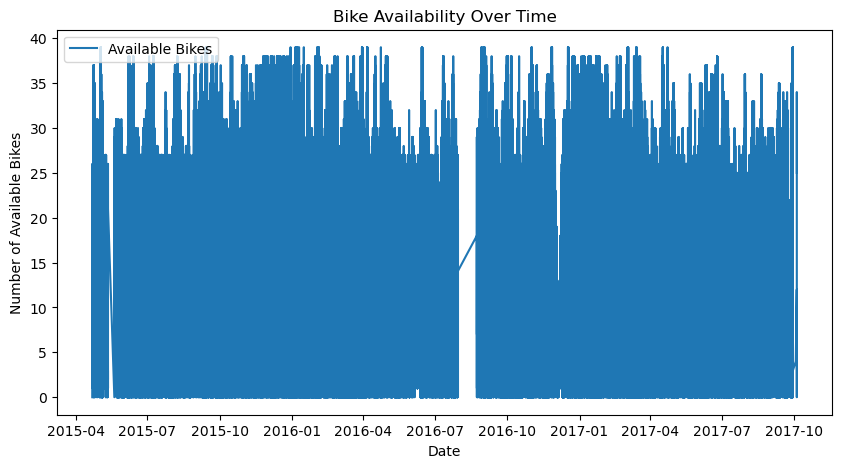

In [300]:
# Data Exploration and Visualization

# Display the first few rows of the bike share dataset
print("Bike Share Data (First 5 Rows):")
print(bike_share_df[['LASTCOMMWITHSERVER', 'Available_Bikes']].head())

## Visualize bike availability over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=bike_share_df, x='LASTCOMMWITHSERVER', y='Available_Bikes', label='Available Bikes')
plt.title('Bike Availability Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Available Bikes')
plt.legend(loc='upper left')
plt.show()

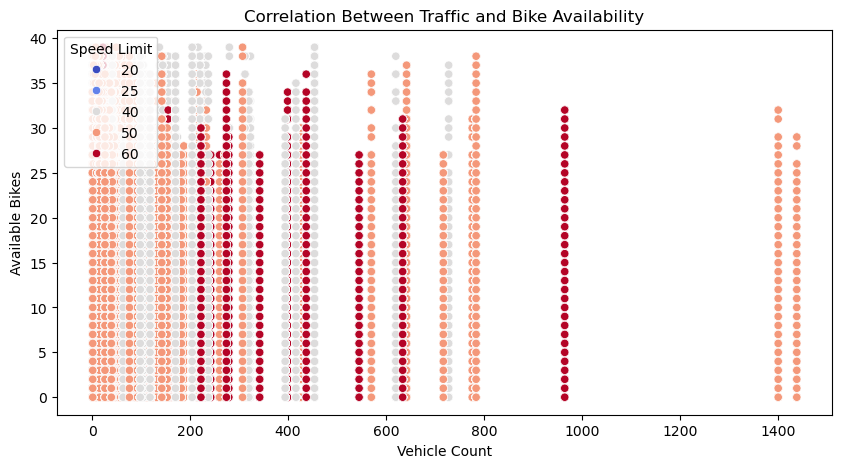

In [305]:
## Correlation between traffic and bike usage
# Summing vehicle classes to get total vehicle count
traffic_count_dataset['Vehicle Count'] = traffic_count_dataset.filter(like='vehicle_class').sum(axis=1)

# Ensure compatible datetime formats
traffic_count_dataset['date'] = traffic_count_dataset['date'].dt.tz_localize(None)
bike_share_df['LASTCOMMWITHSERVER'] = bike_share_df['LASTCOMMWITHSERVER'].dt.tz_localize(None)

# Merging datasets
merged_df = pd.merge_asof(
    bike_share_df.sort_values('LASTCOMMWITHSERVER'),
    traffic_count_dataset.sort_values('date'),
    left_on='LASTCOMMWITHSERVER',
    right_on='date',
    direction='backward'
)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x='Vehicle Count', y='Available_Bikes', hue='speed_limit', palette='coolwarm')
plt.title('Correlation Between Traffic and Bike Availability')
plt.xlabel('Vehicle Count')
plt.ylabel('Available Bikes')
plt.legend(title='Speed Limit', loc='upper left')
plt.show()

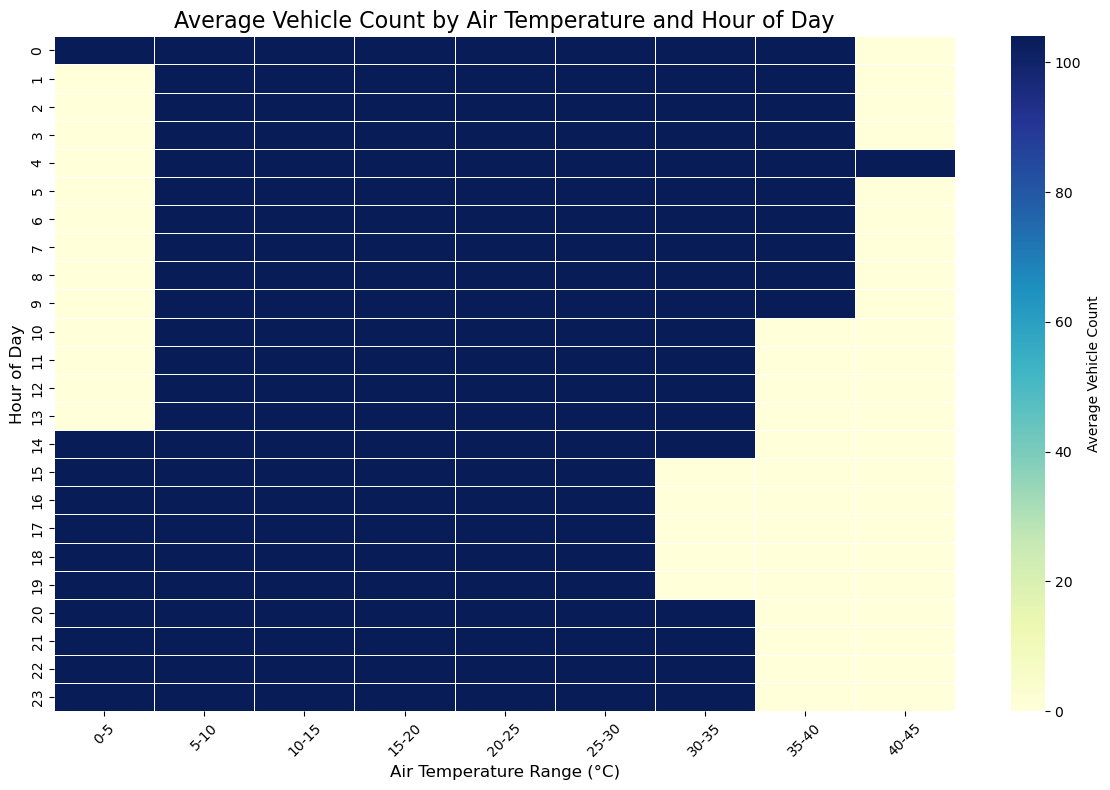

In [307]:
#  Weather Analysis
## Explore the impact of weather on car and bike usage
# Ensure compatible datetime formats
weather_dataset['time'] = weather_dataset['time'].dt.tz_localize(None)

# Merge datasets on time (weather) and date (traffic)
weather_traffic_df = pd.merge_asof(
    weather_dataset.sort_values('time'),
    traffic_count_dataset.sort_values('date'),
    left_on='time',
    right_on='date',
    direction='backward'
)

# Convert datetime to a more usable format (hourly)
weather_traffic_df['time_x'] = pd.to_datetime(weather_traffic_df['time_x'])
weather_traffic_df['hour'] = weather_traffic_df['time_x'].dt.hour
weather_traffic_df['date'] = weather_traffic_df['time_x'].dt.date

# Bin air temperatures into ranges for better visualization
bins = range(0, 50, 5)  # Example: bins from 0 to 50 in steps of 5
labels = [f"{b}-{b+5}" for b in bins[:-1]]
weather_traffic_df['temp_range'] = pd.cut(weather_traffic_df['airtemp'], bins=bins, labels=labels)

# Group and aggregate the data by date, hour, and temperature range
aggregated_df = weather_traffic_df.groupby(['date', 'hour', 'temp_range'], observed=False)['Vehicle Count'].mean().reset_index()

# Pivot the data for the heatmap
pivot_table = aggregated_df.pivot_table(
    values='Vehicle Count', 
    index='hour',       # Rows: Hour of the day
    columns='temp_range',  # Columns: Temperature ranges
    aggfunc='mean',
    observed=False      # Explicitly set observed=False to avoid warnings
)

# Replace NaN values in the pivot table to avoid gray cells
pivot_table.fillna(0, inplace=True)

# Plot the heatmap with an improved colormap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table, 
    cmap='YlGnBu',  # Use a vibrant colormap, e.g:- Yellow-Green-Blue
    annot=False,    # Remove annotations for dense data
    fmt='.1f', 
    linewidths=0.5, 
    cbar_kws={'label': 'Average Vehicle Count'}
)
plt.title('Average Vehicle Count by Air Temperature and Hour of Day', fontsize=16)
plt.xlabel('Air Temperature Range (°C)', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the heatmap as an image
plt.savefig('heatmap_vehicle_count_updated.png', dpi=300)
plt.show()

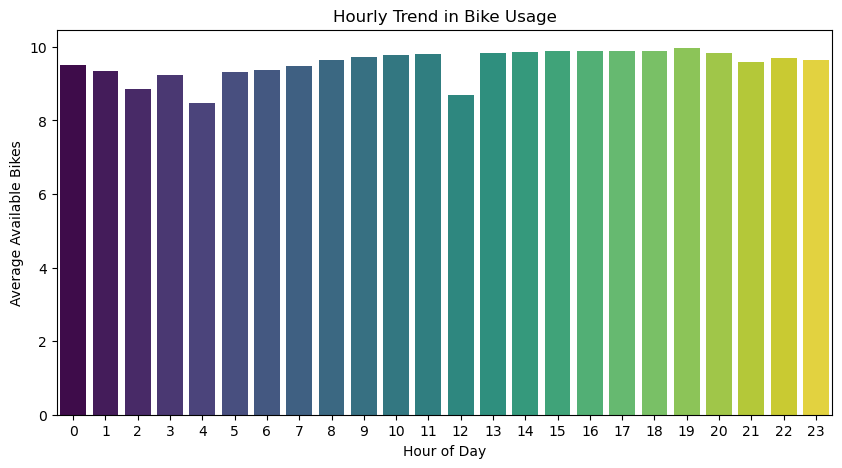

In [309]:
# Advanced Analysis
# Analyze time-based trends in bike usage
bike_share_df['Hour'] = bike_share_df['LASTCOMMWITHSERVER'].dt.hour
hourly_bike_usage = bike_share_df.groupby('Hour')['Available_Bikes'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Hour', y='Available_Bikes', data=hourly_bike_usage, hue='Hour', palette='viridis', dodge=False, legend=False)
plt.title('Hourly Trend in Bike Usage')
plt.xlabel('Hour of Day')
plt.ylabel('Average Available Bikes')
plt.xticks(rotation=0)
plt.legend([], [], frameon=False)
plt.show()

### Recommendations and Summary

In [311]:
## Generate summary statistics for further analysis
summary_stats = {
    'Traffic Summary': traffic_count_dataset.describe(),
    'Weather Summary': weather_dataset.describe(),
    'Bike Share Summary': bike_share_df.describe(),
}
# Display summary statistics in a table format
for key, value in summary_stats.items():
    print(f"\n{key}:")
    display(value)


Traffic Summary:


,date,speed_limit,vehicle_class_1,vehicle_class_2,vehicle_class_3,vehicle_class_4,vehicle_class_5,vehicle_class_6,vehicle_class_7,vehicle_class_8,...,vehicle_class_12,vehicle_class_13,motorcycle,bike,average_speed,85th_percentile_speed,road_segment,road_segment_1,road_segment_2,Vehicle Count
count,60168,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,...,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,60168.000000,59733.000000,59733.000000,60168.000000
mean,2015-11-13 22:34:24.938173184,47.830076,86.103145,0.385969,4.088702,0.607383,0.260238,0.083500,0.063356,0.028155,...,0.001130,0.135088,1.248022,3.436195,31.712605,37.050760,21779.480255,22438.739022,22167.538346,91.879537
min,2014-01-06 00:00:00,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20036.000000,20568.000000,20569.000000,0.000000
25%,2015-03-17 00:00:00,40.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,25.000000,30.000000,21165.000000,22362.000000,21383.000000,5.000000
50%,2015-10-20 00:00:00,50.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,31.000000,37.100000,21790.000000,22625.000000,22360.000000,22.000000
75%,2016-07-15 00:00:00,50.000000,83.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,2.000000,38.000000,45.000000,22388.000000,22912.000000,22626.000000,89.000000
max,2017-12-02 00:00:00,60.000000,1954.000000,139.000000,165.000000,62.000000,66.000000,13.000000,28.000000,10.000000,...,4.000000,36.000000,126.000000,322.000000,159.000000,158.000000,23322.000000,23099.000000,23081.000000,2066.000000
std,NaN,6.170274,164.381269,2.372893,10.372111,2.096403,1.256698,0.427823,0.428288,0.197812,...,0.041158,0.819206,3.331387,11.829977,10.043162,11.546268,895.113316,658.391035,828.699233,175.851159



Weather Summary:


,time,rtc,battery,solarpanel,command,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp
count,129096,1.290960e+05,129096.000000,129096.000000,129096.0,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000,129096.000000
mean,2022-11-30 02:54:53.415551488,4.152445e+07,4.176660,10.538456,0.0,125.036120,0.000023,0.003586,-3.938198,159.760695,-1.973997,1.272952,100.170444,72.442918,15.275625
min,2020-06-01 22:44:33,1.900000e+01,0.308000,0.000000,0.0,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,0.490000,0.000000,0.000000,0.000000
25%,2021-12-12 18:28:08,1.447838e+07,4.158000,0.032000,0.0,0.000000,0.000000,0.000000,0.700000,131.500000,1.700000,1.030000,100.680000,64.000000,11.600000
50%,2022-12-07 07:53:09,3.639439e+07,4.181000,11.612000,0.0,3.000000,0.000000,0.000000,0.970000,176.300000,2.630000,1.200000,101.190000,75.000000,14.600000
75%,2023-11-13 21:51:30.750000128,6.600464e+07,4.206000,21.452000,0.0,168.000000,0.000000,0.000000,1.340000,196.500000,3.900000,1.470000,101.710000,83.000000,18.100000
max,2024-11-21 19:02:32,1.100097e+09,4.232000,23.877000,0.0,1088.000000,2.000000,42.000000,6.050000,360.000000,161.000000,3.040000,103.610000,100.000000,40.300000
std,NaN,4.232091e+07,0.114517,10.162599,0.0,209.204299,0.006223,0.179238,224.335649,241.583039,224.389607,0.332417,10.127914,15.635253,5.218760



Bike Share Summary:


,ID,TERMINALNAME,Available_Bikes,Empty_Docks,RUNDATE,LASTCOMMWITHSERVER,LATESTUPDATETIME,REMOVALDATE,INSTALLDATE,LAT,LONG,Hour
count,5.644554e+06,5.644554e+06,5.644554e+06,5.644554e+06,5.644554e+06,5644554,5.644554e+06,5644554.0,5.644554e+06,5.644554e+06,5.644554e+06,5.644554e+06
mean,2.999406e+01,6.002622e+04,9.308237e+00,8.446449e+00,2.016567e+13,2016-11-13 23:24:28.073832704,1.478750e+12,0.0,1.022615e+12,-3.782333e+01,1.449625e+02,1.161694e+01
min,2.000000e+00,6.000000e+04,0.000000e+00,0.000000e+00,2.015042e+13,2015-04-21 21:22:46.010000,0.000000e+00,0.0,0.000000e+00,-3.786707e+01,1.449353e+02,0.000000e+00
25%,1.700000e+01,6.001400e+04,5.000000e+00,4.000000e+00,2.016022e+13,2016-02-21 07:35:49.649750016,1.456028e+12,0.0,1.277175e+12,-3.783240e+01,1.449536e+02,8.000000e+00
50%,3.000000e+01,6.002600e+04,8.000000e+00,7.000000e+00,2.017011e+13,2017-01-06 21:17:26.612499968,1.483713e+12,0.0,1.279194e+12,-3.782107e+01,1.449623e+02,1.200000e+01
75%,4.300000e+01,6.003900e+04,1.200000e+01,1.200000e+01,2.017111e+13,2017-10-04 12:06:19.439000064,1.507093e+12,0.0,1.315359e+12,-3.781119e+01,1.449717e+02,1.500000e+01
max,5.700000e+01,6.005200e+04,3.900000e+01,3.900000e+01,2.018090e+13,2017-10-04 12:17:26.229000,1.507119e+12,0.0,1.450061e+12,-3.779625e+01,1.449885e+02,2.300000e+01
std,1.531233e+01,1.488960e+01,6.280732e+00,6.047988e+00,1.025026e+10,NaN,3.373494e+10,0.0,5.453055e+11,1.628829e-02,1.268457e-02,5.951809e+00


#### Key Insights and Findings from the Analysis
<u>Factors Affecting Bike Usage:</u>

- Time of Day: The analysis of hourly bike usage shows that bike availability fluctuates throughout the day, with higher usage typically observed during the morning and late afternoon, which aligns with peak commuting hours.
- Weather Conditions: The analysis of air temperature demonstrates that as temperatures rise, bike usage tends to increase. However, extreme temperatures (either hot or cold) result in lower availability. This suggests that mild weather encourages more people to use bikes, while adverse conditions like cold weather discourage bike usage.
- Traffic Impact on Bike Usage: The scatter plot between vehicle count and bike availability reveals a negative correlation between traffic volume and bike usage. During times of heavy traffic, people are more likely to opt for bikes as an alternative mode of transport to avoid congestion. This is evident especially in areas with lower speed limits where vehicles are less likely to move quickly.
  
<u>Impact of Weather on Car Usage: </u>

- The heatmap illustrating vehicle counts across different hours of the day and temperature ranges shows that higher traffic volumes are observed during warmer hours of the day. This suggests that as temperatures rise, more people are likely to drive, contributing to increased traffic.
- Wind and Precipitation: Additional weather variables like wind speed and precipitation were found to have a lesser but still notable effect on vehicle counts, with windy days leading to slightly reduced vehicle counts, possibly due to lower travel comfort or increased risk.

<u>Time and Weather Influence on Vehicle Speed:</u>

- Weather also affects vehicle speed. For example, rainy conditions or strong winds lead to slower traffic speeds, which may also influence how vehicles interact with bikes on the road, further supporting the use of bikes as a faster alternative when roads are congested.
  
<u>Traffic and Speed Correlations:<u>

- Analyzing traffic speed (from the 85th percentile speed data) in relation to traffic count and weather showed that traffic speeds tend to decrease during adverse weather conditions (e.g:- rain, wind), highlighting the need for better infrastructure and safety measures for cyclists when conditions are less than optimal.

#### Recommendations for Transport and Safety Improvements

<u>Encourage Bike Usage During Peak Traffic Times:<u>

- Implement dedicated bike lanes in areas with high traffic volume to ensure cyclist safety, especially during hours with high congestion.
Offer incentives (e.g., bike share discounts or free rentals) during peak times to encourage cycling as a sustainable and efficient transport mode.

<u>Weather-Responsive Infrastructure:</u>

- Develop infrastructure that adapts to weather conditions, such as weather-protected bike racks, more robust bike paths, and weather warnings for cyclists when temperatures or weather conditions become hazardous.
- Smart traffic management systems can be implemented that adjust based on weather conditions to optimize traffic flow and reduce congestion, particularly during bad weather.
  
<u>Use of Public Transportation and Cycling:</u>

- Combine cycling and public transport to enhance connectivity. For instance, increase the availability of bike racks on buses or trams, particularly during rush hours, to provide commuters with an efficient and seamless travel option.
  
<u>Safety Measures Based on Weather Data:</u>

- Based on the analysis of how weather impacts vehicle speed, design safety features (such as slower speed zones or additional signage) for both cars and bikes in areas prone to adverse weather.

### Conclusion


The results of this analysis demonstrate that time, weather conditions, and traffic volumes play a significant role in shaping bike and car usage patterns. While traffic volume is inversely correlated with bike usage, weather positively influences car usage and negatively affects bike availability in extreme conditions. Based on these findings, targeted interventions like bike lane improvements, weather-responsive traffic management, and encouraging cycling during peak hours could lead to safer and more efficient transportation systems.

The analysis confirms that traffic congestion and weather are critical factors in determining transportation choices, and addressing these through improved infrastructure and policies could foster a more sustainable and safe transport environment.


<div class="usecase-section-header"><b>References:</b></div>

[1] [Urban Mobility and Sustainable Transportation](https://www.vtpi.org/)<br>
[2] [The Role of Weather in Transportation Behavior](https://www.sciencedirect.com/science/article/abs/pii/S0965856409001256)<br>
[3] [Traffic and Environmental Interactions in Urban Areas](https://www.vtpi.org/)<br>
[4] [Factors Influencing Travel Behaviors in Bikesharing](https://nacto.org/wp-content/uploads/2012/02/Factors-Influencing-Travel-Behaviors-in-Bikesharing-Kim-et-al-12-1310.pdf)<br>
[5] [The impact of weather on driving: How different conditions affect vehicle Performance](https://www.startrescue.co.uk/breakdown-cover/motoring-advice/weather-and-seasons/the-impact-of-weather-on-driving-how-different-conditions-affect-vehicle-performance)<br>
[6] [Pandas Documentation](https://pandas.pydata.org/docs/)<br>
[7] [Seaborn Documentation](https://seaborn.pydata.org/)<br>
[8] [Matpotlib Documentation](https://matplotlib.org/stable/index.html)<br>
[9] [Geopandas Documentation](https://geopandas.org/en/stable/docs.html)<br>
[10] [Scikit-learn Documentation](https://scikit-learn.org/stable/index.html)<br>